# Ungraded Lab: Multi-class Classifier

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Convolutional_Neural_Networks_in_TensorFlow/Week4/Labs/C2_W4_Lab_1_multi_class_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!


**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Download and Prepare the Dataset

You will be using the [Rock-Paper-Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors), a gallery of hands images in Rock, Paper, and Scissors poses.

In [1]:
%%bash

# Download the train set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
    
# Download the test set
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip

In [2]:
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras import Input, layers, Sequential, utils
import numpy as np

2024-06-12 21:13:16.907967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./rps-test')
zip_ref.close()

!rm *.zip

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [4]:
base_dir = './rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock04-110.png', 'rock07-k03-016.png', 'rock06ck02-054.png', 'rock06ck02-057.png', 'rock06ck02-010.png', 'rock06ck02-070.png', 'rock01-087.png', 'rock03-113.png', 'rock01-070.png', 'rock07-k03-037.png']
['paper06-094.png', 'paper03-028.png', 'paper02-069.png', 'paper07-005.png', 'paper07-107.png', 'paper06-003.png', 'paper07-092.png', 'paper05-063.png', 'paper03-079.png', 'paper04-084.png']
['scissors02-066.png', 'scissors01-097.png', 'testscissors03-070.png', 'scissors04-095.png', 'testscissors01-031.png', 'scissors04-056.png', 'scissors01-084.png', 'scissors03-087.png', 'testscissors02-055.png', 'testscissors03-098.png']


You can also inspect some of the images to see the variety in your model inputs.

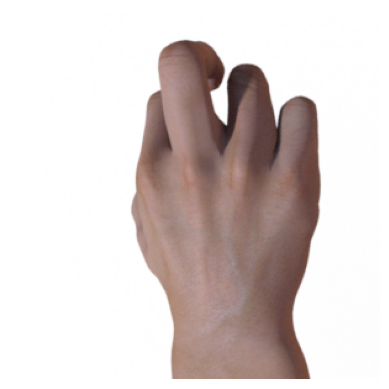

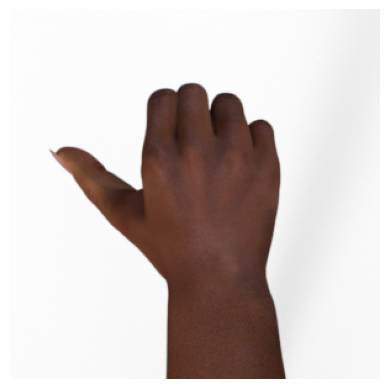

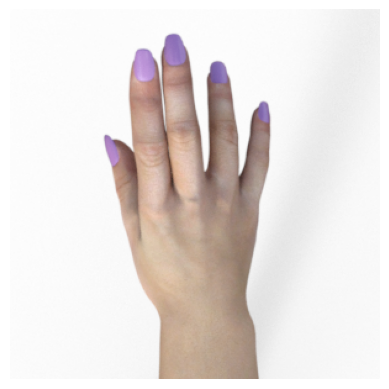

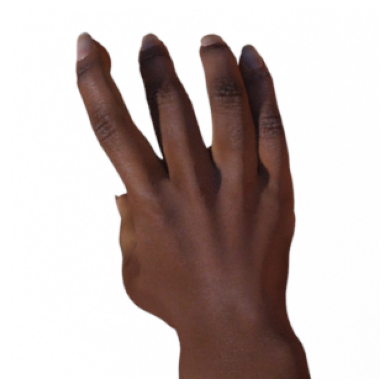

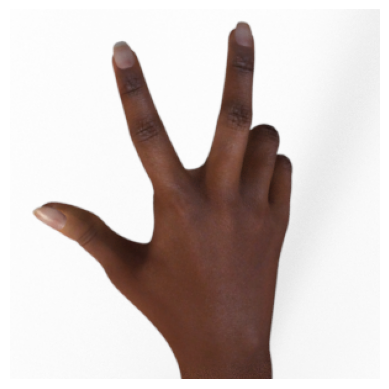

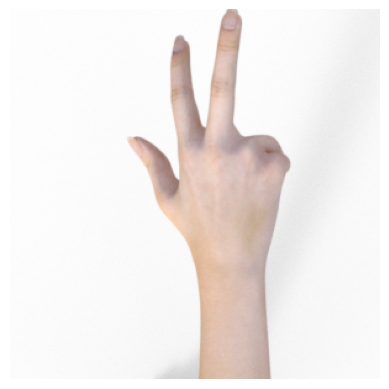

In [5]:
pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index - 2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index - 2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index - 2:pic_index]]

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some Dense layers for the classification. The output layer would be a 3-neuron dense layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be `paper`-`rock`-`scissors` (e.g. a `[0.8 0.2 0.0]` output means the model is prediciting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

In [6]:
augmentation = Sequential([layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                           layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomFlip(mode="horizontal")])

model = Sequential([Input(shape=(150, 150, 3)),
                    augmentation,
                    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
                    # This is the first convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The second convolution
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The third convolution
                    layers.Conv2D(128, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # The fourth convolution
                    layers.Conv2D(128, (3, 3), activation='relu'),
                    layers.MaxPooling2D(2, 2),
                    # Flatten the results to feed into a DNN
                    layers.Flatten(),
                    layers.Dropout(0.5),
                    # 512 neuron hidden layer
                    layers.Dense(512, activation='relu'),
                    layers.Dense(3, activation='softmax')])

# Print the model summary
model.summary()

2024-06-12 21:13:21.155827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1685 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

You will then compile the model. The key change here is the `loss` function. Whereas before you were using `binary_crossentropy` for 2 classes, you will change it to [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function) to extend it to more classes.

In [7]:
# Set the training parameters
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Prepare the ImageDataGenerator

You will prepare the generators as before. You will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [8]:
TRAINING_DIR = "./rps-train/rps"
VALIDATION_DIR = "./rps-test/rps-test-set"

scale = layers.Rescaling(scale=1. / 255)

train_generator = utils.image_dataset_from_directory(directory=TRAINING_DIR,
                                                    #  batch_size=126,
                                                     image_size=(150, 150),
                                                     label_mode='categorical')

validation_generator = utils.image_dataset_from_directory(directory=VALIDATION_DIR,
                                                        #   batch_size=126,
                                                          image_size=(150, 150),
                                                          label_mode='categorical')

train_generator = train_generator.map(lambda image, label: (scale(image), label))
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


## Train the model and evaluate the results

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to only your training set.



In [9]:
# Train the model
history = model.fit(
                    train_generator, 
                    epochs=25, 
                    # steps_per_epoch=20, 
                    validation_data=validation_generator, 
                    verbose=1, 
                    # validation_steps=3
                    )

Epoch 1/25


2024-06-12 21:13:25.230816: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 4/79 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2689 - loss: 1.4466

2024-06-12 21:13:26.972667: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.3191 - loss: 1.1801 - val_accuracy: 0.4677 - val_loss: 1.0750
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4219 - loss: 1.0480 - val_accuracy: 0.6935 - val_loss: 0.6453
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5809 - loss: 0.8450 - val_accuracy: 0.7796 - val_loss: 0.4557
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.6732 - loss: 0.6890 - val_accuracy: 0.9247 - val_loss: 0.1760
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7845 - loss: 0.5112 - val_accuracy: 0.8522 - val_loss: 0.3875
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8255 - loss: 0.4406 - val_accuracy: 0.7392 - val_loss: 0.6387
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8642 - loss: 0.3355 - val_accuracy: 0.9543 - val_loss: 0.1468
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9004 - loss: 0.2650 - val_accuracy: 0.9704 - val_loss: 0

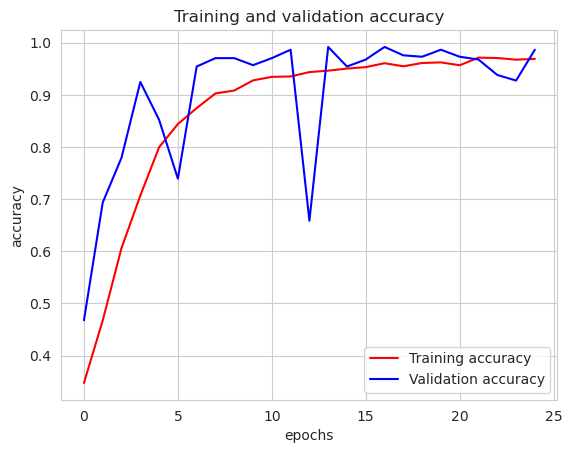

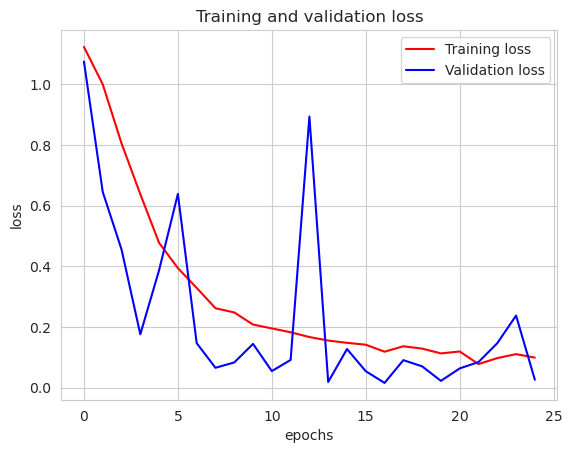

In [10]:
sns.set_style("whitegrid")

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc=0)
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc=0)
plt.show()

# Model Prediction

You should be able to upload an image here and have it classified without crashing. This code block will only work in Google Colab, however. You can use your own images or use the ones available [here](https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-validation.zip)

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

If you're using Safari and the cell above throws an error, you will need to upload the images(s) manually in their workspace.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [11]:
%%bash

mkdir images
wget -q https://upload.wikimedia.org/wikipedia/commons/7/7e/Rock-paper-scissors_%28rock%29.png -O ./images/rock.png

In [12]:
# CODE BLOCK FOR OLDER VERSIONS OF SAFARI

images = os.listdir("./images")

print(images)

for i in images:
    print()
    # predicting images
    path = './images/' + i
    img = utils.load_img(path, target_size=(150, 150))
    x = utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(path)
    print(classes)

['rock.png']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
./images/rock.png
[[0. 1. 0.]]


## Wrap Up

That concludes this short exercise on the multi-class classifiers. You saw that with just a few changes, you were able to convert your binary classifiers to predict more classes. You used the same techniques for data and model preparation and were able to get relatively good results in just 25 epochs. For practice, you can search for other datasets (e.g. [here](https://archive.ics.uci.edu/datasets)) with more classes and revise the model to accomodate it. Try to experiment with different layers and data augmentation techniques to improve your metrics.

In [13]:
!rm -rf ./images ./rps*